### 1. 数据准备
使用torchtext对文本进行预处理

In [1]:
import re
import string
import torch
import torchtext

In [22]:
# 定义几个全局变量
MAX_WORDS = 10000    # 仅考虑词频最高的前10000个词语
MAX_LEN = 200        # 每天语料的最大长度
BATCH_SIZE = 20

In [23]:
# 去除语料中的标点符号，并以空格分词
tokenizer = lambda x: re.sub('[%s]' % string.punctuation, '', x).split(' ')

def filter_low_freq_words(arr, vocab):
    """过滤掉低词频"""
    arr = [[x if x<MAX_WORDS else 0 for x in example] 
           for example in arr]
    return arr
    
# 1.定义各个字段的预处理方法
TEXT = torchtext.data.Field(
    sequential=True,
    tokenize=tokenizer,
    lower=True,
    fix_length=MAX_LEN,
    postprocessing=filter_low_freq_words
)

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)


# 2.构建表格型dataset,下面api可读取csv,tsv,json格式的数据
ds_train, ds_test = torchtext.data.TabularDataset.splits(
    path='./data/imdb/', train='train.tsv', test='test.tsv',
    format='tsv', fields=[('label', LABEL), ('text', TEXT)],
    skip_header=False
)

# 3.构建词典
TEXT.build_vocab(ds_train)

# 4.构建管道迭代器
train_iter, test_iter = torchtext.data.Iterator.splits(
    (ds_train, ds_test), sort_within_batch=True,
    sort_key=lambda x:len(x.text), batch_sizes=(BATCH_SIZE, BATCH_SIZE)
)

In [14]:
# 查看样本信息
print(ds_train[0].text)
print(ds_train[0].label)

['it', 'really', 'boggles', 'my', 'mind', 'when', 'someone', 'comes', 'across', 'a', 'movie', 'like', 'this', 'and', 'claims', 'it', 'to', 'be', 'one', 'of', 'the', 'worst', 'slasher', 'films', 'out', 'there', 'this', 'is', 'by', 'far', 'not', 'one', 'of', 'the', 'worst', 'out', 'there', 'still', 'not', 'a', 'good', 'movie', 'but', 'not', 'the', 'worst', 'nonetheless', 'go', 'see', 'something', 'like', 'death', 'nurse', 'or', 'blood', 'lake', 'and', 'then', 'come', 'back', 'to', 'me', 'and', 'tell', 'me', 'if', 'you', 'think', 'the', 'night', 'brings', 'charlie', 'is', 'the', 'worst', 'the', 'film', 'has', 'decent', 'camera', 'work', 'and', 'editing', 'which', 'is', 'way', 'more', 'than', 'i', 'can', 'say', 'for', 'many', 'more', 'extremely', 'obscure', 'slasher', 'filmsbr', 'br', 'the', 'film', 'doesnt', 'deliver', 'on', 'the', 'onscreen', 'deaths', 'theres', 'one', 'death', 'where', 'you', 'see', 'his', 'pruning', 'saw', 'rip', 'into', 'a', 'neck', 'but', 'all', 'other', 'deaths', 'a

In [20]:
# 查看词典信息
print(len(TEXT.vocab))

# index to string
print(TEXT.vocab.itos[0])     # unkonwn 未知词
print(TEXT.vocab.itos[1])     # padding 填充

# string to index
print(TEXT.vocab.stoi['<pad>'])
print(TEXT.vocab.stoi['it'])

# 词频
print(TEXT.vocab.freqs['<unk>'])
print(TEXT.vocab.freqs['good'])

108197
<unk>
<pad>
1
9
0
11457


In [24]:
# 查看管道数据信息: text第0维是句子长度
for batch in train_iter:
    features = batch.text
    labels = batch.label
    print(features)
    print(features.shape)
    print(labels)
    break

tensor([[   2,  102,    0,  ...,    4,    0,   11],
        [  51, 2079,   13,  ..., 2200,   16,   18],
        [   0,   44,  685,  ...,    8,   32,    7],
        ...,
        [   8, 1653,  111,  ...,    1,    1,    1],
        [4077, 6271,  119,  ...,    1,    1,    1],
        [9412,  135,   88,  ...,    1,    1,    1]])
torch.Size([200, 20])
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])


In [63]:
# 将管道数据使用Dataloader的形式输出
class DataLoader:
    def __init__(self, data_iter):
        self.data_iter = data_iter
        # self.length = len(data_iter)
        
    def __len__(self):
        return len(self.data_iter)
    
    def __iter__(self):
        for batch in self.data_iter:
            yield (torch.transpose(batch.text, 0, 1),
                  torch.unsqueeze(batch.label.float(), dim=1))
            
dl_train = DataLoader(train_iter)
dl_test = DataLoader(test_iter)

### 2.定义模型
使用nn.Module 基类构建模型并辅助应用模型容器

In [28]:
import torchkeras
from torch import nn

In [41]:
torch.random.seed()


class Net(torchkeras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=MAX_WORDS,
            embedding_dim=3,
            padding_idx=1
        )
        self.conv = nn.Sequential()
        self.conv.add_module(
            'conv_1',
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5)
        )
        self.conv.add_module('pool_1', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_1', nn.ReLU())
        self.conv.add_module(
            'conv_2',
            nn.Conv1d(in_channels=16, out_channels=128, kernel_size=2)
        )   # kernel_size: 卷积核尺寸
        self.conv.add_module('pool_2', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_2', nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module('flatten', nn.Flatten())
        self.dense.add_module('linear', nn.Linear(6144, 1))
        self.dense.add_module('sigmoid', nn.Sigmoid())
        
    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.conv(x)
        y = self.dense(x)
        return y

In [42]:
model = Net()
print(model)
model.summary(input_shape=(200,), input_dtype=torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten()
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5              [-1, 128, 97]  

### 3. 训练模型
此处使用类形式训练循环，仿照Keras定义了一个高阶的模型接口Model,实现 fit, validate，predict, summary 方法，相当于用户自定义高阶API

In [43]:
# 定义准确率函数
def accuracy(y_pred, y_true):
    y_pred = torch.where(
        y_pred > 0.5,
        torch.ones_like(y_pred, dtype=torch.float32),
        torch.zeros_like(y_pred, dtype=torch.float32)
    )
    acc = torch.mean(1 - torch.abs(y_true - y_pred))
    return acc


model.compile(
    loss_func=nn.BCELoss(),
    optimizer=torch.optim.Adagrad(
        model.parameters(),
        lr=0.02,
    ),
    metrics_dict={'accuracy': accuracy}
)

In [51]:
history = model.fit(20, dl_train, dl_val=dl_test, log_step_freq=200)

{'step': 600, 'loss': 0.226, 'accuracy': 0.916}
{'step': 800, 'loss': 0.231, 'accuracy': 0.913}
{'step': 1000, 'loss': 0.232, 'accuracy': 0.911}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   16  | 0.232 |  0.911   |  0.507   |    0.781     |
+-------+-------+----------+----------+--------------+

================================================================================2020-10-22 19:51:56
{'step': 200, 'loss': 0.222, 'accuracy': 0.919}
{'step': 400, 'loss': 0.219, 'accuracy': 0.92}
{'step': 600, 'loss': 0.221, 'accuracy': 0.918}
{'step': 800, 'loss': 0.22, 'accuracy': 0.918}
{'step': 1000, 'loss': 0.222, 'accuracy': 0.917}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   17  | 0.222 |  0.917   |  0.511   |    0.785     |
+-------+-------

### 4. 模型评估

In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(facecolor='w')
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

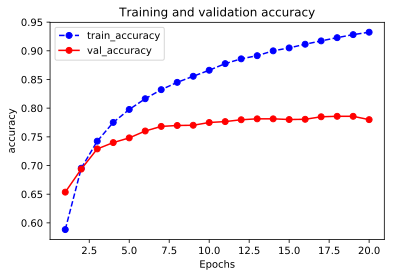

In [59]:
plot_metric(history, 'accuracy')

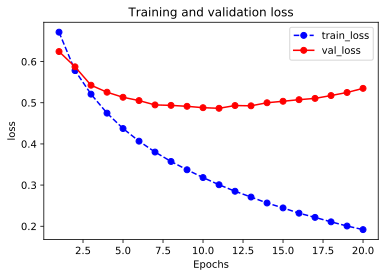

In [61]:
plot_metric(history, 'loss')

In [64]:
# 评估
model.evaluate(dl_test)

{'val_loss': 0.5349447662830353, 'val_accuracy': 0.7800000007152558}

### 5. 使用模型

In [65]:
model.predict(dl_test)

tensor([[0.0113],
        [0.9673],
        [0.2522],
        ...,
        [0.9985],
        [0.9937],
        [0.0110]])